# Tutorial 9 - Time series

In lecture 9 (Advanced Structure Discovery), we studied different distance and similarity measures and explored the challenges of time-series data. 
For handling time series data, we covered five strategies including: aggregating features over time, using fixed time intervals, and Dynamic Time Warping.

In this tutorial, you will get hands-on experience on the first three strategies covered in class to handle time-series data and discover structures in the data. 

**Learning Objectives**

- Comparing three strategies to handle time-series data: aggregating features over time, using fixed time intervals, and Dynamic Time Warping.
- Clustering time-series data to identify different student patterns.
- Exploring the hyperparameters of DTW and Spectral Clustering.

In [1]:
# Add imports here
import numpy as np
import pandas as pd 

### BEGIN SOLUTION
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
mpl.rc('image', cmap='rainbow')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, \
                            pairwise_distances, pairwise_kernels
from scipy.sparse.csgraph import laplacian
from scipy import linalg
from scipy.spatial import distance

from tslearn.metrics import cdist_dtw
### END SOLUTION

from tutorial08 import get_heuristics_spectral
%load_ext autoreload
%autoreload 2

SEED = 111

/home/paola/Documents/ML4E/MLBD/Grading/mlbd/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 0. Dataset
---
In this tutorial, we will explore different distance metrics to cluster students based on their learning patterns. We are mainly interested in exploring **procrastination**.

For this purpose, we will cluster the data of 30 high-school students and their usage of an academic learning platform. The dataset has the number of hours per biweek of the year that each student spent on the platform. 

The dataset contains the following columns:
- **student id:** unique student identifier
- **biweek of the year:** number of the biweek of the school year. biweek 0 means the first two weeks of the September
- **hours:** number of hours the student spent on the platform for that particular biweek
- **student type:** expert tagging of student behavior where (1) is procrastinators, (2) regular students, and (3) precrastinators. Given that this feature we would normally not have, we will not use it until the last exercise.

The data is in the file `'hours_biweek_students.csv'`

In [2]:
df = pd.read_csv('data/hours_biweek_students.csv')
df.head()

,student_id,biweek_of_year,hours,student_type
0,0,0,39.915507,3
1,0,1,32.356082,3
2,0,2,17.456692,3
3,0,3,16.012725,3
4,0,4,15.859812,3


# 1. Data Preparation
---

The first step is to extract the time series per student. Your task is to reshape the DataFrame into an array of shape (students, biweeks).

In the array, each row must represent one student and each column the number of hours the student used the educational platform per bi-week of the year.

In other words, the data should be aggregated by student (rows) and by biweeks (columns).
The column 1 (`data[0,:]`, should be the number of hours the students used the platform in the first biweek of the school year. Whereas the first row (`data[:,0]`) should be all the observations for the first student.  
Finally, `data[i,j]` must have the number of hours for student `i` on biweek `j`.

In [3]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    ### BEGIN SOLUTION
    df_array = (df.sort_values(['student_id', 'biweek_of_year'], ascending=True)
                .groupby('student_id')
                .agg({'hours': lambda x: list(x)}))

    data = np.asarray(df_array.hours.values.tolist())
    ### END SOLUTION
    return data


data = get_time_series(df)
data.shape

(30, 27)

# 2. Data Visualization
---

Let's see how the students' time-series look like. 
Complete the function `plot_students` and plot the time-series of the 30 students in whichever way you think is most informative.

Can you visually identify some possible clusters or patterns from the plots?

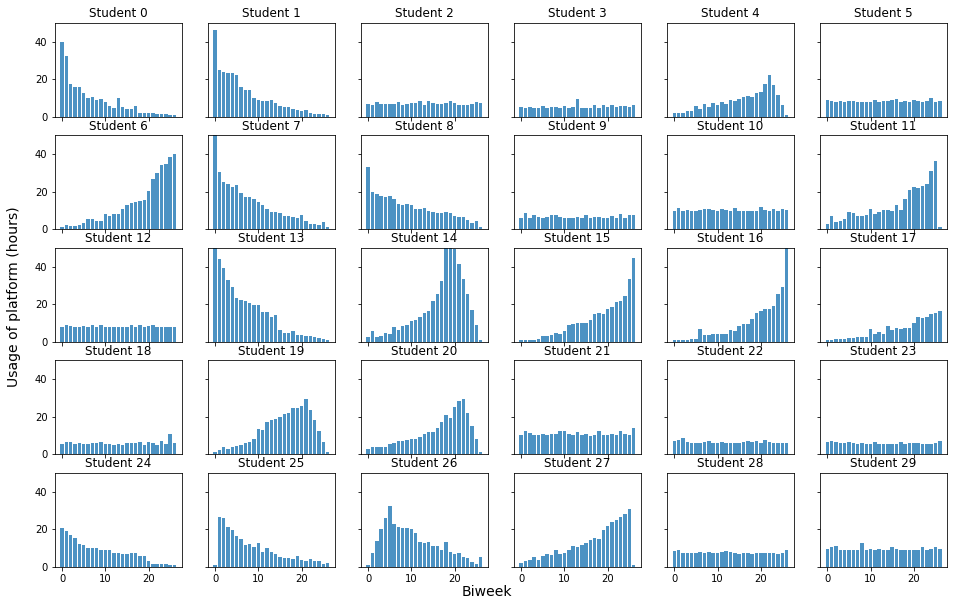

In [4]:
def plot_students(data):
    """
    Plot the students time-series
    :param data: np.array with students' time-series
    :return: 
    """
    ### BEGIN SOLUTION
    students, biweeks = data.shape
    fig, axs = plt.subplots(5, 6, figsize=(16, 10), sharex=True,
                            sharey=True, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(students):
        axs[i].bar(range(biweeks), data[i], alpha=0.8)
        axs[i].set_ylim([0, 50])
        axs[i].set_title('Student {0}'.format(i))
    fig.text(0.5, 0.09, 'Biweek', va='center', ha='center', fontsize=14)
    fig.text(0.09, 0.5, 'Usage of platform (hours)', va='center', ha='center', rotation='vertical', fontsize=14)
    ### END SOLUTION


plot_students(data)

# 3. Data aggregation
---

## 3.1 Aggregate data
The first method we will explore is aggregating features over time. We will first compute the value of the feature over the whole time series (average, maximum, range) and visualize the distribution for all students.

**Hint**: You can visualize the distribution with a histogram. 

Can you visually identify some clusters?

Text(0, 0.5, 'Frequency')

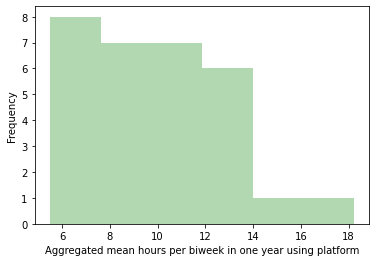

In [5]:
### BEGIN SOLUTION
# compute the value of the feature over the whole time series
aggregated_data = np.mean(data, axis = 1)
# plot the histogram of the feature for all students
plt.hist(aggregated_data, bins = 6, alpha = 0.3, color = 'green')
plt.xlabel('Aggregated mean hours per biweek in one year using platform')
plt.ylabel('Frequency')
### END SOLUTION

## 3.2 Compute affinity matrix
Building on top of the last tutorial, we will cluster the data using Spectral Clustering.
Recall that one of the first steps for Spectral Clustering is to build an affinity matrix. 
During tutorial 8, we computed the affinity/similarity matrix by computing a graph of the nearest neighbors.

As seen in lecture 9, there are other distances and similarity measures that can be used depending on the problem. Your task is to generate matrix `S` containing the simiñarity matrix for the aggregated data. 


**Hint**:
In class, we explored in detail the Gaussian Kernel with Euclidean distance that takes into account the local neighborhood.

$$
S(x, y)=e^{-\frac{\|x-y\|_{2}^{2}}{2 \sigma^{2}}}
$$

where $ \sigma $ is a hyperparameter that should be tuned, for now, we can give it a value of 1. We will explore this hyperparameter in detail in 5.6.


<AxesSubplot:>

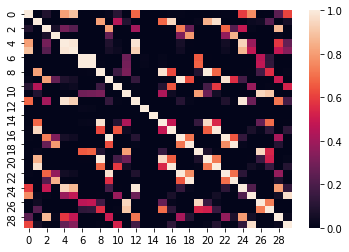

In [6]:
### BEGIN SOLUTION
# OPTION A
# 1. Calculate distance matrix first
D = pairwise_distances(aggregated_data.reshape(-1, 1), metric = 'euclidean')
# 2. Computing kernel
gamma = 1
S = np.exp(-gamma * D ** 2)

# OPTION B
# Directly computing the kernel
S = pairwise_kernels(aggregated_data.reshape(-1, 1), metric = 'rbf', gamma = gamma)

# Visualize kernel
sns.heatmap(S)
### END SOLUTION

## 3.3 Cluster affinity matrix
Building on top of last tutorial, we will cluster the data using Spectral Clustering.

Your task is to adapt last tutorial's function `spectral_clustering` to accept the precomputed affinity matrix as input.  

**Hint** You can use an extra parameter indicating the type of affinity


In [7]:
def spectral_clustering(X, n_clusters, affinity = 'nearest_neighbors'):
    """
    Spectral clustering
    :param X: np array of data points or affinity matrix
    :param n_clusters: number of clusters
    :param affinity: str indicating the type of input
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    ### BEGIN SOLUTION
    if affinity == 'nearest_neighbors':
        # Construct a similarity graph
        n_neighbors = 8
        connectivity = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity')
        adjacency_matrix = (1 / 2) * (connectivity + connectivity.T)

        # Compute the unnormalized graph Laplacian
        L = laplacian(csgraph=adjacency_matrix, normed=False)
        L = L.toarray()
    elif affinity == 'precomputed':
        # Assume affinity matrix has already been computed
        L = laplacian(X, normed=True)        

    # Compute the first 𝑘 eigenvectors
    eigenvals, eigenvcts = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)

    eigenvals_sorted_indices = np.argsort(eigenvals)
    eigenvals_sorted = eigenvals[eigenvals_sorted_indices]
    indices = eigenvals_sorted_indices[: n_clusters]
    proj_X = eigenvcts[:, indices.squeeze()]

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(proj_X)
    ### END SOLUTION
    return kmeans, proj_X, eigenvals_sorted


## 3.4 Optimal number of clusters

You may re-use the function `get_heuristics_spectral` from tutorial 8 to select the optimal number of clusters.

What is the optimal number of clusters?

**Hint:** The function is in the file `tutorial08.py`


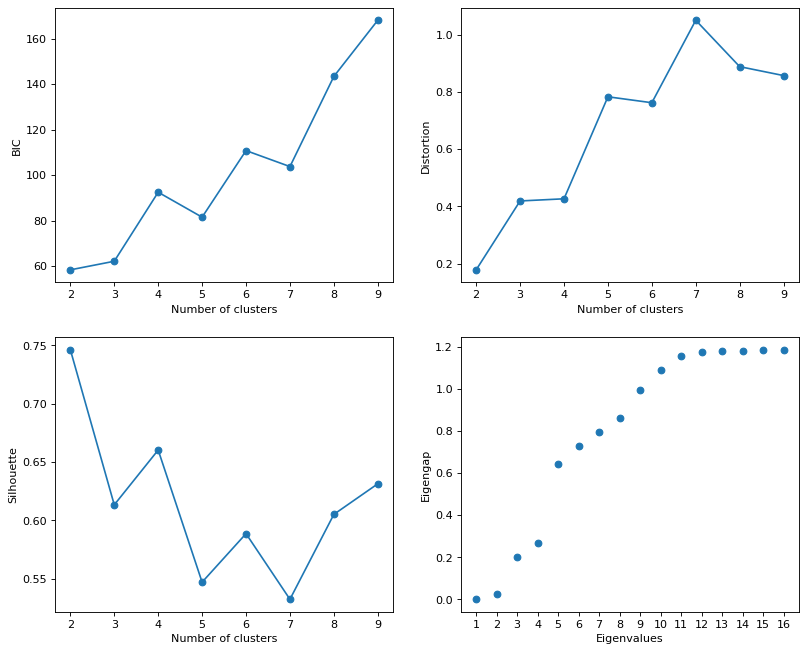

In [8]:
### BEGIN SOLUTION
get_heuristics_spectral(S)
### END SOLUTION

## 3.5 Visualize the clusters

Using the optimal number of clusters from 3.4 , visualize the different time-series of students belonging to each cluster. 

What can you say about each cluster? Were the clusters correctly identified?

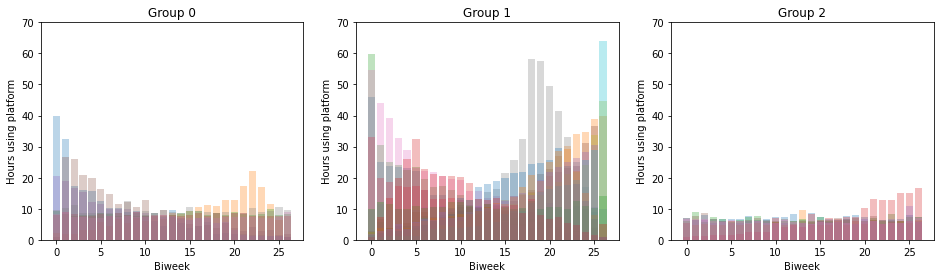

In [9]:
def view_clusters(data, labels):
    """
    visualize the different time-series of students belonging to each cluster. 
    :param data: np.array with students' time-series
    :param labels: np.array predicted labels from clustering model
    :return: 
    """
    ### BEGIN SOLUTION
    _, biweeks = data.shape
    clusters = np.unique(labels).shape[0]
    fig, axs = plt.subplots(1, clusters, figsize=(16, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i in range(clusters):
        students_cluster = data[labels == i]
        number_students = students_cluster.shape[0]
        for student in range(number_students):
            axs[i].bar(range(biweeks), students_cluster[student], alpha=0.3)
        axs[i].set_ylim([0, 70])
        axs[i].set_title('Group {0}'.format(i))
        axs[i].set_ylabel('Hours using platform')
        axs[i].set_xlabel('Biweek')
    ### END SOLUTION
        
kmeans, proj_X, eigenvals_sorted = spectral_clustering(S, 3, affinity='precomputed')
labels = kmeans.labels_
view_clusters(data, labels)

# 4. Using fixed time intervals

The second strategy covered in class was using fixed time intervals. We can use standard distance measures once we have feature vectors with the same length for every student.

## 4.1 Compute distance matrix

We first need to compute the distance matrix of the feature vectors (data matrix) with an appropriate distance metric. The data matrix computed in (1) already contains the feature vectors of the same length. Your task is to calculate the pairwise distances between the vectors (rows of data matrix) and build a distance matrix with the resulting distances.

**Hint**: If we are interested in capturing the different shapes, we can first compute the unit vectors (dividing each vector by its norm). 

In [10]:
def get_distance_matrix(X, metric='euclidean'):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :return: np.array with distance matrix
    """
    ### BEGIN SOLUTION
    # normalize vectors
    norms = np.linalg.norm(X, axis=1)
    data_normalized = X / norms[:, np.newaxis]

    # compute distance matrix
    distance_vector = distance.pdist(data_normalized, metric)
    distance_matrix = distance.squareform(distance_vector)
    ### END SOLUTION
    return distance_matrix


D = get_distance_matrix(data)

## 4.2 Compute affinity matrix
Similar to what we did in (3.2), we can compute the affinity matrix from the distance matrix by applying a Gaussian kernel. 

In [11]:
def get_affinity_matrix(D, gamma=1):
    """
    calculates affinity matrix from distance matrix
    :param D: np.array distance matrix
    :param gamma: float coefficient for Gaussian Kernel
    :return:
    """
    ### BEGIN SOLUTION
    S = np.exp(-gamma * D ** 2)
    ### END SOLUTION
    return S


S = get_affinity_matrix(D)

## 4.3 Optimal number of clusters

What is the optimal number of clusters? How does this differ from the results from the aggregated feature?
Is there more agreement or less between the different metrics?


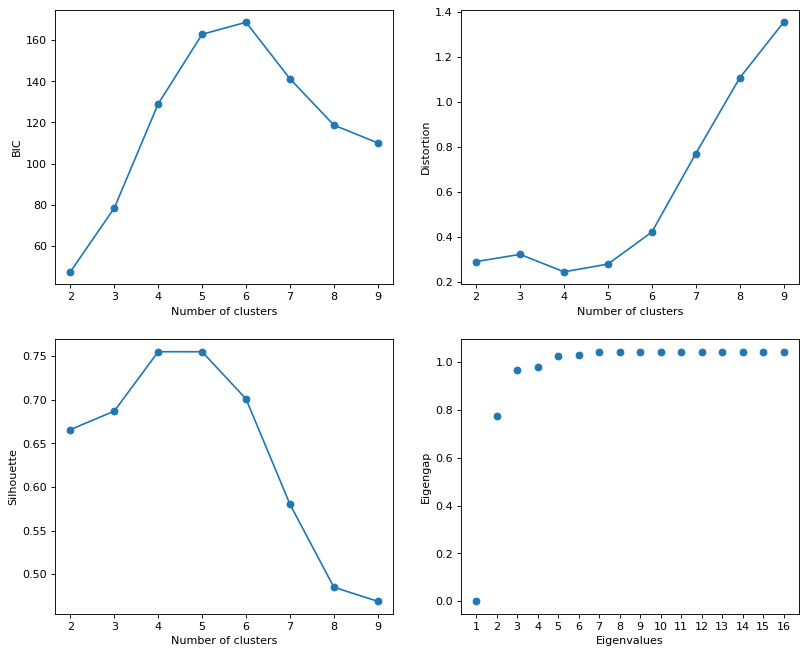

In [12]:
### BEGIN SOLUTION
get_heuristics_spectral(S)
### END SOLUTION


## 4.4 Visualize the clusters

Using the optimal number of clusters from 4.3, visualize the different time-series of students belonging to each cluster. 

What can you say about each cluster? Were the clusters correctly identified? How are the results different from the clusters found with the aggregated data?

**Hint** re-use your functions

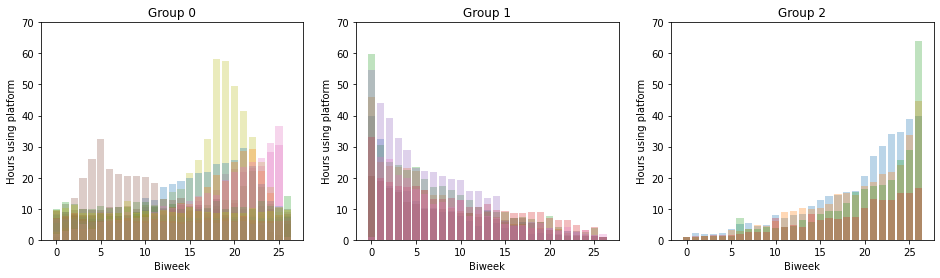

In [13]:
### BEGIN SOLUTION
kmeans, proj_X, eigenvals_sorted = spectral_clustering(S, 3 , affinity = 'precomputed')
labels = kmeans.labels_
view_clusters(data, labels)
### END SOLUTION

# 5. Dynamic Time Warping
---

Dynamic Time Warping is useful when we want to compute the distance between two time series that vary in speed. It works by finding the optimal alignment between two time-series. 

Let's see how it can be applied to this example.

## 5.1 Compute distance matrix

Modify the function `get_distance_matrix` to calculate the distance matrix using DTW.

**Hint**: You can use libraries like fastdtw or tslearn.

**Challenge**: Implement DTW with numpy following the lecture slides.


In [14]:
def get_distance_matrix(X, metric='euclidean', window=2):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :param window: int for DTW
    :return: np.array with distance matrix
    """
    ### BEGIN SOLUTION
    norms = np.linalg.norm(X, axis=1)
    data_normalized = X / norms[:, np.newaxis]

    if metric == 'dtw':
        distance_matrix = cdist_dtw(data_normalized,
                                    global_constraint='sakoe_chiba',
                                    sakoe_chiba_radius=window)
    else:
        distance_vector = distance.pdist(data_normalized, metric)
        distance_matrix = distance.squareform(distance_vector)
    ### END SOLUTION
    return distance_matrix


D = get_distance_matrix(data, metric='dtw', window=6)

## 5.2 Compute affinity matrix

**Hint** re-use your functions

In [15]:
### BEGIN SOLUTION
S = get_affinity_matrix(D)
### END SOLUTION

## 5.3 Optimal number of clusters

What is the optimal number of clusters? How does this differ from the results of (3) and (4)?

Is there more agreement or less between the different metrics?

**Hint** re-use your functions

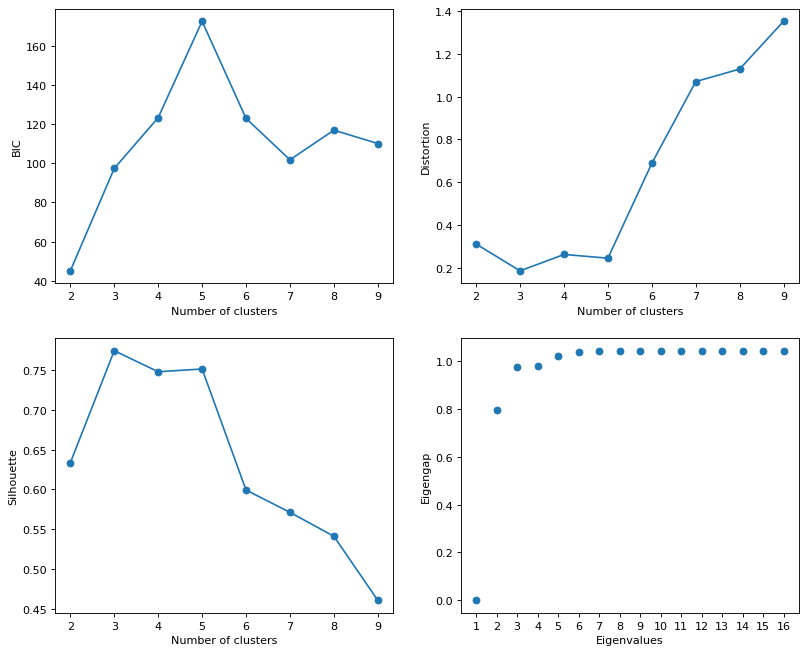

In [16]:
### BEGIN SOLUTION
get_heuristics_spectral(S)
### END SOLUTION

## 5.4 Visualize the clusters

Using the optimal number of clusters from (5.3), visualize the different time-series of students belonging to each cluster. 

What can you say about each cluster? Were the clusters correctly identified? How are the results different from the clusters found in (3) and (4)?

**Hint** re-use your functions

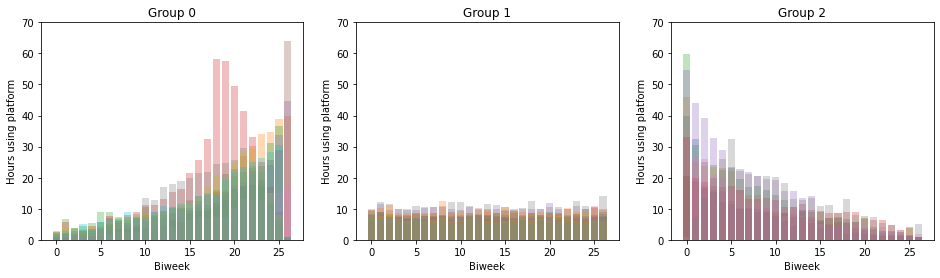

In [17]:
### BEGIN SOLUTION
kmeans, proj_X, eigenvals_sorted = spectral_clustering(S, 3 , affinity = 'precomputed')
labels = kmeans.labels_
view_clusters(data, labels)
### END SOLUTION

## 5.5 Window size

As seen during the lecture, sometimes we are interested in constraining the mapping. 

How do the results vary when changing the window size?

Which window size makes more sense?

What happens when the window is very small? What happens when the window is very large?

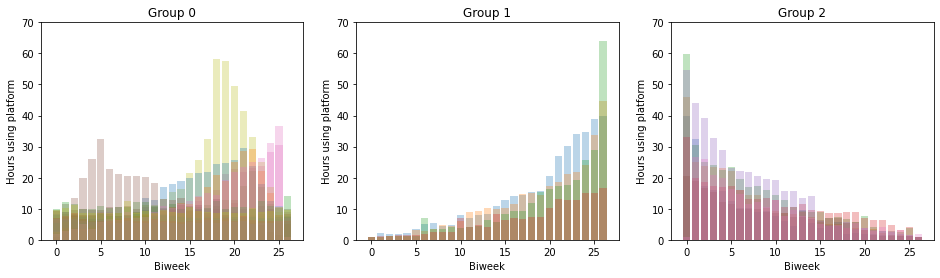

In [18]:
D = get_distance_matrix(data, metric = 'dtw', window = 0)
S = get_affinity_matrix(D)
kmeans, proj_X, eigenvals_sorted = spectral_clustering(S, 3 , affinity = 'precomputed')
labels = kmeans.labels_
view_clusters(data, labels)

## 5.6 Gamma and window size
Up until now, we have used the data in a completely unsupervised way. 
For this last exercise, we are going to use the expert tagging to understand the effect of the window size and the parameter gamma. 

### 5.6.1 Get the student types

Using the column student_type from the original DataFrame (df), obtain the student type for each student.

We will compare this labels to the ones generated by the model. 

In [19]:
def get_student_types(df):
    """
    recovers student type for all students
    :param df: pd.DataFrame with data in long format
    :return: np.array shaped (number of students,) with student types
    """
    ### BEGIN SOLUTION
    students_types = np.array(df.groupby('student_id')['student_type'].max().tolist())
    ### END SOLUTION
    return students_types


students_types = get_student_types(df)

### 5.6.2 Supervised metrics

In rare ocasions, the real cluster labels are known and it is possible to measure the similarity of the predicted labels and the real labels. 

One of this metrics is the Rand Index. The adjusted Rand Index has a value of 0 for random labelling and 1 for identical labelling. 


In [20]:
score = adjusted_rand_score(labels, students_types)
score

0.4250745486122489

### 5.6.3 Explore different window sizes and values for gamma 
How does the performance (adjusted Rand Index) vary?
What conclusions can you draw?
What can you infer about the role of the gamma parameter? 

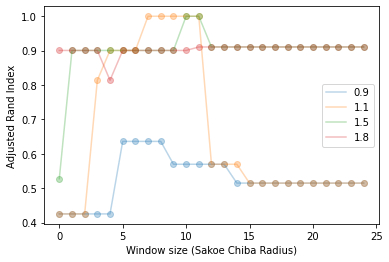

In [21]:
### BEGIN SOLUTION
clusters = 3
current_gamma = 1
max_window = 25
gamma_list = [0.9, 1.1, 1.5, 1.8]
for current_gamma in gamma_list:
    scores_list = []
    for i in range(max_window):
        D = get_distance_matrix(data, metric='dtw', window=i)
        S = get_affinity_matrix(D, gamma=current_gamma)
        kmeans, proj_X, eigenvals_sorted = spectral_clustering(S, clusters, affinity='precomputed')
        labels = kmeans.labels_
        score = adjusted_rand_score(labels, students_types)
        scores_list.append(score)

    plt.scatter(range(max_window), np.array(scores_list), alpha=0.3)
    plt.plot(range(max_window), np.array(scores_list), label=current_gamma, alpha=0.3)

plt.xlabel('Window size (Sakoe Chiba Radius)')
plt.ylabel('Adjusted Rand Index')
plt.legend()
### END SOLUTION

# 6. Summary 

In this tutorial, you used three strategies to handle time-series data (aggregating features over time, using fixed time intervals, and Dynamic Time Warping). With these strategies, you clustered time-series to identify meaningful student patterns and explored the hyperparameters of DTW and Spectral Clustering.

**Lab discussion** 
What are the limitations of each strategy?

# Bonus Challenge

Replicate the analysis for `bonus_challenge.csv`. What other challenges do you encounter?
